# Logistic Regression Model: Predicting sentiment from product reviews


The goal of this first notebook is to explore logistic regression and feature engineering with a model created from scratch.

In this notebook we will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.
## Fire up [Sframe](https://github.com/dato-code/SFrame)

In [1]:
import sframe

## Loading data
amazon_reviews.csv es la unión de varios datasets (ver notebook Data Engineering)

In [2]:
reviews = sframe.SFrame('babies+pets_reviews.csv')

2016-06-11 18:18:52,288 [INFO] sframe.cython.cy_server, 172: SFrame v1.9 started. Logging /tmp/sframe_server_1465661932.log


Unable to parse line ""121431","B0050O92FU","[,0,,, ,0,]","We purchased our Goodbyn lunchboxes at a local retail store recently and the kids have officially started using them. I find that the deep compartments are great to fill with snacks and different variety for school lunc..."

Unable to parse line ""42764","B000FP68KQ","[,0,,, ,0,]","I love this item, very easy to go on easy to use harness clip and she loves to wear it","05 3, 2014","A3IPRBCQK9JWD0","Mz. B$$ ""L. Bennett""","harness dress\","1399075200","i love item easy go easy use harness clip love..."

Unable to parse line ""112687","B0040QOYZ2","[,0,,, ,0,]","I have a Shiba Inu & she sheds SoO much. I bought the Furminator shampoo with the medium long hair comb. When I brush her it's like a razor blade edging her hair off on the top & stripping it. The hair that come off of ..."

Unable to parse line ""123868","B004WSBZAA","[,1,,, ,3,]","I disliked the packaging and lack of information on the product itself and had to go hunting around the internet to find more information on how to administer/feed it to my dog. Powders are generally inconvenient and th..."

4 lines failed to parse correctly

Finished parsing file /home/dsc/Repositories/ProyectoFinMasterDataScience/babies+pets_reviews.csv

Parsing completed. Parsed 318624 lines in 4.62094 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,list,str,str,str,str,str,int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


# Exploring Data 1/6
Let us quickly explore more of this dataset.
1. We count the number of positive and negative reviews 
2. list the first 10 products in the dataset.

In [3]:
len(reviews)

318624

In [4]:
reviews.print_rows(num_rows=2, num_columns=10)

+----+------------+-------------------------------+
| X1 |    asin    |            helpful            |
+----+------------+-------------------------------+
| 0  | 097293751X | [None, 0, None, None, None... |
| 1  | 097293751X | [None, 0, None, None, None... |
+----+------------+-------------------------------+
+-------------------------------+-------------+----------------+
|           reviewText          |  reviewTime |   reviewerID   |
+-------------------------------+-------------+----------------+
| Perfect for new parents. W... | 07 16, 2013 | A1HK2FQW6KXQB2 |
| This book is such a life s... | 06 29, 2013 | A19K65VY14D13R |
+-------------------------------+-------------+----------------+
+-------------------------------+-------------------------------+----------------+
|          reviewerName         |            summary            | unixReviewTime |
+-------------------------------+-------------------------------+----------------+
| Amanda Johnsen "Amanda E. ... |            Awes

# Data Engineering: defining reviews with positive or negative sentiment

We'll call data engineering, just defining what is a positive and negative sentiment. So let's do that right now. So in the subsection we're gonna define what's a positive and a negative sentiment.
And so I'm gonna make an arbitrary choice here:
1. Let's say that things that 4, 5 stars are things that people liked. So those are positives. 
2. Things that 1 and 2 stars are negative. 
3. ignore all 3 star reviews.
So I'm gonna say a positive sentiment equals 4 star or 5 star reviews. So let's go ahead and add a new column to our table that defines the actual sentiment. So products new column called sentiment.

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [5]:
reviews = reviews[reviews['review_overall'] != 3]
len(reviews)

285437

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [6]:
reviews['review_sentiment'] = reviews['review_overall'].apply(lambda rating : +1 if rating > 3 else -1)
reviews.print_rows(num_rows=2, num_columns=10)

+----+------------+-------------------------------+
| X1 |    asin    |            helpful            |
+----+------------+-------------------------------+
| 0  | 097293751X | [None, 0, None, None, None... |
| 1  | 097293751X | [None, 0, None, None, None... |
+----+------------+-------------------------------+
+-------------------------------+-------------+----------------+
|           reviewText          |  reviewTime |   reviewerID   |
+-------------------------------+-------------+----------------+
| Perfect for new parents. W... | 07 16, 2013 | A1HK2FQW6KXQB2 |
| This book is such a life s... | 06 29, 2013 | A19K65VY14D13R |
+-------------------------------+-------------+----------------+
+-------------------------------+-------------------------------+----------------+
|          reviewerName         |            summary            | unixReviewTime |
+-------------------------------+-------------------------------+----------------+
| Amanda Johnsen "Amanda E. ... |            Awes

### Subsample dataset to make sure classes are balanced
Just as we did in the previous assignment, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We use `seed=1` so everyone gets the same results.

In [7]:
positive_reviews_raw = reviews[reviews['review_sentiment'] == 1]
negative_reviews_raw  = reviews[reviews['review_sentiment'] == -1]

# Undersample the reviews.
percentage = len(negative_reviews_raw)/float(len(positive_reviews_raw))
negative_reviews = negative_reviews_raw
positive_reviews = positive_reviews_raw.sample(percentage, seed=1)
products = negative_reviews_raw.append(positive_reviews)

print "Percentage of positive reviews             :", len(positive_reviews) / float(len(products))
print "Percentage of negative reviews             :", len(negative_reviews) / float(len(products))
print "Total number of reviews in our new dataset :", len(products)

Percentage of positive reviews             : 0.50116556825
Percentage of negative reviews             : 0.49883443175
Total number of reviews in our new dataset : 69494


# Exploring Data 2/6
Let us quickly explore more of this dataset.
1. We count the number of positive and negative reviews.
2. Modify the subset to contain similar numbers of positive and negative reviews, as the original dataset consisted primarily of positive reviews.

In [8]:
print '# of positive reviews =', len(reviews[reviews['review_sentiment']==1])
print '# of negative reviews =', len(reviews[reviews['review_sentiment']==-1])

# of positive reviews = 250771
# of negative reviews = 34666


In [9]:
print '# of positive balanced reviews =', len(products[products['review_sentiment']==1])
print '# of negative balanced reviews =', len(products[products['review_sentiment']==-1])

# of positive balanced reviews = 34828
# of negative balanced reviews = 34666


# Reviews Extraction Phase: data preparation. 
## (desarrollado en el notebook Data Engineering)
**Note:** 
 - column review_clean with text cleaning developed in Data Engineering notebook
 - building features: la lista de palabras important_words.json se confecciona en el nb Data Engineering

**Note:** There are several ways of doing this. We use the built-in *count* function for Python lists. Each **review without punctuation, stopwords, etc** string is first split into individual words and the number of occurances of a given word is counted.
1. Transform the reviews into word-counts (only for **important_words**, without punctuation, stopwords, etc)
2. For each word in **important_words**, we compute a count for the number of times the word occurs in the review. We will store this count in a separate column (one for each word). The result of this feature processing is a single column for each word in **important_words** which keeps a count of the number of times the respective word occurs in the review text.

Now, we will load these words from this JSON file:

In [10]:
import json
with open('important_words_1500.json', 'r') as f: # Reads the list of words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

In [11]:
len(important_words)

1500

In [12]:
print important_words

['i', 'wa', 'one', 'the', 'dog', 'like', 'love', 'it', 'baby', 'get', 'would', 'use', 'great', 'ha', 'cat', 'this', 'my', 'time', 'little', 'well', 'really', 'product', 'toy', 'also', 'good', 'dont', 'much', 'we', 'month', 'work', 'food', 'easy', 'make', 'put', 'old', 'even', 'seat', 'still', 'bought', 'bag', 'keep', 'used', 'they', 'thing', 'two', 'fit', 'back', 'first', 'go', 'bottle', 'doesnt', 'around', 'its', 'doe', 'small', 'day', 'im', 'got', 'using', 'size', 'need', 'take', 'water', 'think', 'son', 'since', 'year', 'better', '2', 'could', 'enough', 'didnt', 'recommend', 'way', 'buy', 'nice', 'made', 'diaper', 'price', 'clean', 'lot', 'come', 'treat', 'look', 'problem', 'he', 'long', 'big', 'bit', 'ive', 'she', 'see', 'daughter', 'car', 'side', 'every', 'play', 'want', 'hold', 'give', 'know', 'stroller', 'sure', 'so', 'right', '3', 'cant', 'week', 'if', 'these', 'perfect', 'seems', 'box', 'though', 'without', 'easily', 'tried', 'never', 'litter', 'but', 'say', 'soft', 'cup', 'ne

In [13]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

# Exploring Data 3/6

The SFrame **products** now contains one column for each of the **important_words**. As an example, the column **perfect** contains a count of the number of times the word **perfect** occurs in each of the reviews.

In [14]:
products['perfect']

dtype: int
Rows: 69494
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... ]

Now, write some code to compute the number of product reviews that contain the word **perfect**.
* First create a column called `contains_perfect` which is set to 1 if the count of the word **perfect** (stored in column **perfect**) is >= 1.
* Sum the number of 1s in the column `contains_perfect`.

In [15]:
products['contains_perfect'] = products['perfect'].apply(lambda s : +1 if s >= 1 else 0)

In [16]:
products['contains_perfect'].sum()

3516

# Implementing logistic regression from scratch

## link function (estimating conditional probability)

Recall from lecture that the link function is given by:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ represents the word counts of **important_words** in the review  $\mathbf{x}_i$.

In [17]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''

def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    scores = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1.0 / (1.0 + np.exp(-scores))

    return predictions

How the link function works with matrix algebra?

Since the word counts are stored as columns in **feature_matrix**, each $i$-th row of the matrix corresponds to the feature vector $h(\mathbf{x}_i)$:
$$
[\text{feature_matrix}] =
\left[
\begin{array}{c}
h(\mathbf{x}_1)^T \\
h(\mathbf{x}_2)^T \\
\vdots \\
h(\mathbf{x}_N)^T
\end{array}
\right] =
\left[
\begin{array}{cccc}
h_0(\mathbf{x}_1) & h_1(\mathbf{x}_1) & \cdots & h_D(\mathbf{x}_1) \\
h_0(\mathbf{x}_2) & h_1(\mathbf{x}_2) & \cdots & h_D(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
h_0(\mathbf{x}_N) & h_1(\mathbf{x}_N) & \cdots & h_D(\mathbf{x}_N)
\end{array}
\right]
$$

By the rules of matrix multiplication, the score vector containing elements $\mathbf{w}^T h(\mathbf{x}_i)$ is obtained by multiplying **feature_matrix** and the coefficient vector $\mathbf{w}$.
$$
[\text{score}] =
[\text{feature_matrix}]\mathbf{w} =
\left[
\begin{array}{c}
h(\mathbf{x}_1)^T \\
h(\mathbf{x}_2)^T \\
\vdots \\
h(\mathbf{x}_N)^T
\end{array}
\right]
\mathbf{w}
= \left[
\begin{array}{c}
h(\mathbf{x}_1)^T\mathbf{w} \\
h(\mathbf{x}_2)^T\mathbf{w} \\
\vdots \\
h(\mathbf{x}_N)^T\mathbf{w}
\end{array}
\right]
= \left[
\begin{array}{c}
\mathbf{w}^T h(\mathbf{x}_1) \\
\mathbf{w}^T h(\mathbf{x}_2) \\
\vdots \\
\mathbf{w}^T h(\mathbf{x}_N)
\end{array}
\right]
$$

## Compute derivative of log likelihood with respect to a single coefficient

Recall:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

Function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. The function accepts two arguments:
* `errors` vector containing $\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ for all $i$.
* `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$. 

In [18]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)
    
    # Return the derivative
    return derivative

We introduced a transformation of this likelihood---called the log likelihood---that simplifies the derivation of the gradient and is more numerically stable.  Due to its numerical stability, we will use the log likelihood instead of the likelihood to assess the algorithm.

The log likelihood is computed using the following formula (see the advanced optional video if you are curious about the derivation of this equation):

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

Function to compute the log likelihood for the entire dataset.

In [19]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)
    return lp

## Taking gradient steps
Now we are ready to implement our own logistic regression. 

Function to solve the logistic regression model using gradient ascent:

In [20]:
from math import sqrt

def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):

        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            derivative = np.dot(errors,feature_matrix[:,j])
            
            # add the step size times the derivative to the current coefficient
            coefficients[j] = coefficients[j] + derivative*step_size
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

# Resolving a sentiment classifier with logistic regression

## Split data into training and test sets
Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [21]:
train_data, test_data = products.random_split(.8, seed=1)

In [22]:
# Warning: This may take a few minutes...
print '# of total reviews =', len(products)
print '# of positive reviews on all data =', len(products[products['review_sentiment']==1])
print '# of negative reviews on all data =', len(products[products['review_sentiment']==-1])

# of total reviews = 69494
# of positive reviews on all data = 34828
# of negative reviews on all data = 34666


In [23]:
# Warning: This may take a few minutes...
print '# of train_data reviews =', len(train_data)
print '# of positive reviews on train data =', len(train_data[train_data['review_sentiment']==1])
print '# of negative reviews on train data =', len(train_data[train_data['review_sentiment']==-1])

# of train_data reviews = 55656
# of positive reviews on train data = 27945
# of negative reviews on train data = 27711


In [24]:
# Warning: This may take a few minutes...
print '# of test_data reviews =', len(test_data)
print '# of positive reviews on test data =', len(test_data[test_data['review_sentiment']==1])
print '# of negative reviews on test data =', len(test_data[test_data['review_sentiment']==-1])

# of test_data reviews = 13838
# of positive reviews on test data = 6883
# of negative reviews on test data = 6955


## SFrame to NumPy array
NumPy is a powerful library for doing matrix manipulation. Let us convert our data to matrices and then implement our algorithms with matrices.

Function that extracts columns from an SFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. The feature matrix includes an additional column 'intercept' to take account of the intercept term.

In [25]:
import numpy as np
def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

def get_numpy_feature_matrix(data_sframe, features):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    return(feature_matrix)

# Training Set

Let us convert the train_data into NumPy arrays.

In [26]:
# Warning: This may take a few minutes...
train_feature_matrix, train_sentiment = get_numpy_data(train_data, important_words, 'review_sentiment') 

In [27]:
train_feature_matrix.shape

(55656, 1501)

## Creating the sentiment classifier on the training data

In [28]:
# Warning: This may take a few minutes...
#Atención el número de ceros debe coincidir con el número de palabras más uno.
sentiment_model_coefficients = logistic_regression(train_feature_matrix, train_sentiment, initial_coefficients=np.zeros(train_feature_matrix.shape[1]),
                                   step_size=1e-7, max_iter=301)

iteration   0: log likelihood of observed labels = -38562.67628793
iteration   1: log likelihood of observed labels = -38547.92839729
iteration   2: log likelihood of observed labels = -38533.53122155
iteration   3: log likelihood of observed labels = -38519.46182750
iteration   4: log likelihood of observed labels = -38505.69883314
iteration   5: log likelihood of observed labels = -38492.22230924
iteration   6: log likelihood of observed labels = -38479.01368605
iteration   7: log likelihood of observed labels = -38466.05566491
iteration   8: log likelihood of observed labels = -38453.33213469
iteration   9: log likelihood of observed labels = -38440.82809307
iteration  10: log likelihood of observed labels = -38428.52957232
iteration  11: log likelihood of observed labels = -38416.42356962
iteration  12: log likelihood of observed labels = -38404.49798155
iteration  13: log likelihood of observed labels = -38392.74154273
iteration  14: log likelihood of observed labels = -38381.1437

## Class predictions from scores

Class predictions for a data point $\mathbf{x}$ can be computed from the coefficients $\mathbf{w}$ using the following formula:
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & \mathbf{x}_i^T\mathbf{w} > 0 \\
      -1 & \mathbf{x}_i^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

Now, we will write some code to compute class predictions. We will do this in two steps:
* **Step 1**: First compute the **scores** using **feature_matrix** and **coefficients** using a dot product.
* **Step 2**: Using the formula above, compute the class predictions from the scores.

Step 1 can be implemented as follows:

In [29]:
# Step 1: Compute the scores as a dot product between feature_matrix and coefficients.
scores = np.dot(train_feature_matrix, sentiment_model_coefficients)

In [30]:
# Step 2: compute the class predictions using the **scores** obtained above:
train_sentiment_predictions = map((lambda score: +1 if score > 0 else -1), scores)

## Measuring accuracy of the model

We will now measure the classification accuracy of the model. 
In accuracy, instead of measuring the number of errors, we measure the number of correct classifications.
So the ratio here is number of correct divided by total number of sentences. 
In terms of accuracy, the best possible value is 1, I've got all the sentences right. 
The classification accuracy can be computed as follows:

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

In [31]:
num_mistakes = (train_sentiment != train_sentiment_predictions).sum()
accuracy = 1.0 * (len(train_data) - num_mistakes) / len(train_data)
print "-----------------------------------------------------"
print '# Reviews   correctly classified =', len(train_data) - num_mistakes
print '# Reviews incorrectly classified =', num_mistakes
print '# Reviews total                  =', len(train_data)
print "-----------------------------------------------------"
print 'Accuracy = %.2f' % accuracy

-----------------------------------------------------
# Reviews   correctly classified = 40657
# Reviews incorrectly classified = 14999
# Reviews total                  = 55656
-----------------------------------------------------
Accuracy = 0.73


# Exploring Data 4/6
## Which words contribute most to positive & negative sentiments?

We were able to compute the "**most positive words**". These are words that correspond most strongly with positive reviews. In order to do this, we will first do the following:
* Treat each coefficient as a tuple, i.e. (**word**, **coefficient_value**).
* Sort all the (**word**, **coefficient_value**) tuples by **coefficient_value** in descending order.

In [32]:
sentiment_model_coefficients_without_intercept = list(sentiment_model_coefficients[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, sentiment_model_coefficients_without_intercept)]

Now, **word_coefficient_tuples** contains a sorted list of (**word**, **coefficient_value**) tuples. The first 10 elements in this list correspond to the words that are most positive.

### Twenty "most positive" words

Now, we compute the 10 words that have the most positive coefficient values. These words are associated with positive sentiment.

In [69]:
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)

In [ ]:
word_coefficient_tuples[0:20]

In [73]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline  


###  Most possitive words cloud

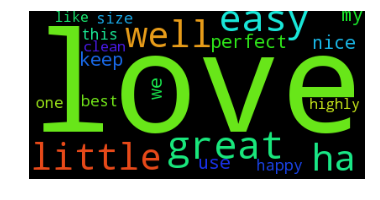

In [74]:
wordcloud = WordCloud(relative_scaling=.1).generate_from_frequencies(word_coefficient_tuples[0:20])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Twenty "most negative" words

Next, we repeat this exercise on the 10 most negative words.  That is, we compute the 10 words that have the most negative coefficient values. These words are associated with negative sentiment.

In [35]:
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=False)

In [65]:
word_coefficient_tuples[0:20]

[('wa', -0.076910539667272848),
 ('would', -0.047993502855058948),
 ('money', -0.033634663138491436),
 ('i', -0.032149370426236744),
 ('product', -0.031188689049810522),
 ('didnt', -0.03108731671996507),
 ('even', -0.027071648853798525),
 ('not', -0.026410486153495703),
 ('waste', -0.025332366949353691),
 ('thought', -0.021359972210361015),
 ('disappointed', -0.019572581111056395),
 ('review', -0.018478903812761505),
 ('return', -0.018263749740310576),
 ('tried', -0.017464678580141557),
 ('work', -0.017452131489125368),
 ('maybe', -0.016783110263799327),
 ('back', -0.016378378470142032),
 ('plastic', -0.015812374453428448),
 ('better', -0.015453283971803381),
 ('dont', -0.015375793067250303)]

### Most negative words cloud

In [75]:
negativeWordsDf = pd.DataFrame(word_coefficient_tuples[0:20], columns=['word','probability'])

def absProbability(row):
    return row["probability"].abs()
negativeWordsDf['probability']=absProbability(negativeWordsDf)
negativeData = [tuple(x) for x in negativeWordsDf.values]
wordcloud = WordCloud(relative_scaling=.1).generate_from_frequencies(negativeData)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

NameError: name 'pd' is not defined

# Test Set. Making predictions with logistic regression
Now that a model is trained, we can make predictions on the **test data**.

In [37]:
# We need to convert test_data into the sparse matrix format first.
# Warning: This may take a few minutes...
test_feature_matrix, test_sentiment = get_numpy_data(test_data, important_words, 'review_sentiment')

In [38]:
# Step 1: Compute the scores as a dot product between feature_matrix and coefficients.
scores = np.dot(test_feature_matrix, sentiment_model_coefficients)

In [39]:
# Step 2: compute the class predictions using the **scores** obtained above:
test_sentiment_predictions = map((lambda score: +1 if score > 0 else -1), scores)

## Accuracy on Test Set

In [40]:
num_test_mistakes = (test_sentiment != test_sentiment_predictions).sum()
accuracy = 1.0 * (len(test_data) - num_test_mistakes) / len(test_data)
print "-----------------------------------------------------"
print '# Reviews   correctly classified =', len(test_data) - num_test_mistakes
print '# Reviews incorrectly classified =', num_test_mistakes
print '# Reviews total                  =', len(test_data)
print "-----------------------------------------------------"
print 'Accuracy = %.2f' % accuracy

-----------------------------------------------------
# Reviews   correctly classified = 10093
# Reviews incorrectly classified = 3745
# Reviews total                  = 13838
-----------------------------------------------------
Accuracy = 0.73


# Exploring Data 5/6
## Applying the learned model to understand sentiment for reviews

In [41]:
test_data['predicted_sentiment'] = scores

### Most positive reviews

In [42]:
test_data = test_data.sort('predicted_sentiment', ascending=False)

In [43]:
test_data[['predicted_sentiment','review_sentiment','review_overall','reviewText']][0:5]

predicted_sentiment,review_sentiment,review_overall,reviewText
1.42348470882,-1,2.0,"As parents of two littleones, I'd like to say we ..."
1.34794398256,1,5.0,"I am dog trainer, andbought this 3 years ago. ..."
1.06514149467,1,5.0,We LOVE our Kinderwagonhop! We were gifted a ...
1.01840714957,1,5.0,I got these from toys rus which is slightly ...
1.00403213387,1,5.0,This is the best purchasewe have made for our ...


In [44]:
# Most positive review
test_data[0]['reviewText']

"As parents of two little ones, I'd like to say we are experts in appreciating different baby bottle designs and what works best for baby.  Here's our criteria for a baby bottle and where the Munchkin fails to win us over:Our Baby Bottle Criteria:====================First and foremost,BABY MUST LIKE IT!---------------------------------Munchkin Latch Bottle:Fails here because the nipple easily collapses.  Just a very slight pressure with your finger and the nipple collapses.  Now, imagine a moving baby with a slurping motion and this nipple collapses too easily.Avent Classic Bottle:We have a dozen of these from our firstborn.  Unfortunately, our son just won't take these.  We tried all of the nipple sizes from NB to level 3, he just won't take it.  We had learned long ago to just get 1 bottle of each type, because different babies like different bottles, no rhyme or reason.  Our daughter loved these.Avent Natural Flow bottle/nipple:He will actually finish a full bottle with this, but th

### Most negative reviews

In [45]:
test_data = test_data.sort('predicted_sentiment', ascending=True)

In [46]:
test_data[['predicted_sentiment','review_sentiment','review_overall','reviewText']][0:5]

predicted_sentiment,review_sentiment,review_overall,reviewText
-2.62204847336,1,4.0,"First, I got this barkcollar after I read ..."
-2.42360251781,-1,1.0,So I read many reviews onthis product and watched ...
-2.40900888545,-1,1.0,My advice on the BrightStarts Sugar Blossom ...
-2.10396332731,-1,1.0,I know that phenotypesdon't always match ...
-2.07412331939,-1,1.0,I purchased the monitorthrough Amazon and was ...


In [47]:
# Most negative review
test_data[0]['reviewText']

'First, I got this bark collar after I read detail review by nursetype "nursetype"  I really appreciate it.  I really had very bad experience with "Petiner Basic No bark control collar". That collar nearly kill my dog.  I also tried "PetSafe Bark Collar"  before Petiner Basic No bark control collar, but my dog did not learn to stop barking.When I saw this Dogwidgets collar, I like the fact that the unnecessary barking or excessive barking can be remotely control by me.  This way, I can only send signals to the dogs when it\'s necessary.  I have 2 dogs and this remote control 2 dogs at the same time is also fantastic bonus.My dogs are small, 4 lbs and 7 lbs little paws.  I was told this may not work for my dog since they are so small, but I was desperate, so I ordered it.This is what I\'ve done for my dogs when I first received Dogwidgets.The collar (straps) is too long and heavy duty for my tiny dogs. I was expect this to be the case before I ordered it, so I knew I have to make some a

# Exploring Data 6/6: 
# TODO: Applying the learned model to discover insights on twitter

## Tweets Extraction Phase: data preparation. 
### (desarrollado en el notebook Data Engineering)
**Note:** 
 - column text_clean with text cleaning developed in Data Engineering notebook

In [48]:
tweets_data = sframe.SFrame('us_tweets.csv')

Unable to parse line ""11","737913129292730368","holy shit"

Unable to parse line "@thebottlemen @ Webster Hall https://t.co/9Gh0dnaEih","Wed Jun 01 07:46:14 +0000 2016","40.7319055","-73.9896578","Manhattan, NY","holy shit thebottlemen webster hall http tco9gh0dnaeih""

Unable to parse line ""50","737913394355941376","still awake"

Unable to parse line "Help","Wed Jun 01 07:47:17 +0000 2016","40.86898882","-73.89397491","Bronx, NY","still awake help""

Unable to parse line ""74","737913609787977728","moderate rain -&gt; mist"

Unable to parse line "humidity down 100% -&gt; 88%"

Unable to parse line "wind 5mph -&gt; 6mph","Wed Jun 01 07:48:09 +0000 2016","44.96","-89.63","Wausau, WI","moderate rain gt mist humidity 100 gt 88 wind 5mph gt 6mph""

Unable to parse line ""97","737913775223885824","$649,000 - 25 Gable Ct, San Rafael, CA 94903: "

Unable to parse line "Next Open House: June 4, 2016"

Unable to parse line "Updated: the open ho... https://t.co/Gob4dXnDEF #marinhomes","Wed Jun 01 07:48:48 +0000 2016","38.003638","-122.535809","San Rafael, CA","649000 25 gable ct san rafael ca 94903 next open house june 4 2016 updated open ho http tcogob4dxndef marinhomes""

924 lines failed to parse correctly

Finished parsing file /home/dsc/Repositories/ProyectoFinMasterDataScience/us_tweets.csv

Parsing completed. Parsed 100 lines in 0.251936 secs.

Unable to parse line ""11","737913129292730368","holy shit"

Unable to parse line "@thebottlemen @ Webster Hall https://t.co/9Gh0dnaEih","Wed Jun 01 07:46:14 +0000 2016","40.7319055","-73.9896578","Manhattan, NY","holy shit thebottlemen webster hall http tco9gh0dnaeih""

Unable to parse line ""50","737913394355941376","still awake"

Unable to parse line "Help","Wed Jun 01 07:47:17 +0000 2016","40.86898882","-73.89397491","Bronx, NY","still awake help""

Unable to parse line ""74","737913609787977728","moderate rain -&gt; mist"

Unable to parse line "humidity down 100% -&gt; 88%"

Unable to parse line "wind 5mph -&gt; 6mph","Wed Jun 01 07:48:09 +0000 2016","44.96","-89.63","Wausau, WI","moderate rain gt mist humidity 100 gt 88 wind 5mph gt 6mph""

Unable to parse line ""97","737913775223885824","$649,000 - 25 Gable Ct, San Rafael, CA 94903: "

Unable to parse line "Next Open House: June 4, 2016"

Unable to parse line "Updated: the open ho... https://t.co/Gob4dXnDEF #marinhomes","Wed Jun 01 07:48:48 +0000 2016","38.003638","-122.535809","San Rafael, CA","649000 25 gable ct san rafael ca 94903 next open house june 4 2016 updated open ho http tcogob4dxndef marinhomes""

930 lines failed to parse correctly

Finished parsing file /home/dsc/Repositories/ProyectoFinMasterDataScience/us_tweets.csv

Parsing completed. Parsed 5623 lines in 0.071426 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,str,str,float,float,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


In [49]:
len(tweets_data)

5623

In [50]:
tweets_data.column_names

<bound method SFrame.column_names of Columns:
	X1	int
	tweet_id	int
	tweet_text	str
	tweet_created_at	str
	tweet_geo_lat	float
	tweet_geo_lon	float
	tweet_city	str
	text_clean	str

Rows: 5623

Data:
+----+--------------------+-------------------------------+
| X1 |      tweet_id      |           tweet_text          |
+----+--------------------+-------------------------------+
| 0  | 737913052050423808 | Supplemental Health Care #... |
| 1  | 737913053119959040 | Can you recommend anyone f... |
| 2  | 737913055338713089 |    https://t.co/DZVgUmv8ZQ    |
| 6  | 737913086837940226 | HCR108 [Passed] Requests t... |
| 7  | 737913096543588352 | SB64 [Vetoed] Baltimore Co... |
| 8  | 737913098217132032 | Just posted a video @ Rol-... |
| 9  | 737913106752540672 | HB349 [Passed] Baltimore C... |
| 12 | 737913131683446784 | Website Hacks to Trap more... |
| 13 | 737913141993078784 | I'm at C-View Inn in Cape ... |
| 14 | 737913142232162304 | geo e92dc4e56c6b97210b3383... |
+----+---------------

In [51]:
for word in important_words:
    tweets_data[word] = tweets_data['text_clean'].apply(lambda s : s.split().count(word))

In [52]:
# We need to convert test_data into the sparse matrix format first.
# Warning: This may take a few minutes...
tweets_feature_matrix  = get_numpy_feature_matrix(tweets_data, important_words) 

In [53]:
# Step 1: Compute the scores as a dot product between feature_matrix and coefficients.
scores = np.dot(tweets_feature_matrix, sentiment_model_coefficients)

In [54]:
tweets_data['predicted_sentiment'] = scores

## Export to json array to d3 visualization

## Most positive tweets

In [55]:
tweets_data = tweets_data.sort('predicted_sentiment', ascending=False)

In [56]:
tweets_data[['tweet_id','predicted_sentiment','tweet_text','tweet_geo_lat','tweet_geo_lon','tweet_city']][0:2]

Columns:
	tweet_id	int
	predicted_sentiment	float
	tweet_text	str
	tweet_geo_lat	float
	tweet_geo_lon	float
	tweet_city	str

Rows: 2

Data:
+--------------------+---------------------+-------------------------------+
|      tweet_id      | predicted_sentiment |           tweet_text          |
+--------------------+---------------------+-------------------------------+
| 737923350970929152 |    0.349616680061   | One cannot think well, lov... |
| 737945729784786944 |    0.173955399084   | Happy Birthday to the best... |
+--------------------+---------------------+-------------------------------+
+---------------+---------------+-----------------+
| tweet_geo_lat | tweet_geo_lon |    tweet_city   |
+---------------+---------------+-----------------+
|  37.69894361  | -123.01177393 | California, USA |
|  40.75224945  |  -73.93153195 |    Queens, NY   |
+---------------+---------------+-----------------+
[2 rows x 6 columns]

In [57]:
positive_tweets_data = tweets_data[['tweet_id','predicted_sentiment','tweet_text','tweet_geo_lat','tweet_geo_lon','tweet_city']][0:15]

In [58]:
positive_tweets_data.export_json('d3/data/USA-positive.json')

## Most negative tweets

In [59]:
tweets_data = tweets_data.sort('predicted_sentiment', ascending=True)

In [60]:
tweets_data[['tweet_id','predicted_sentiment','tweet_text','tweet_geo_lat','tweet_geo_lon','tweet_city']][0:2]

Columns:
	tweet_id	int
	predicted_sentiment	float
	tweet_text	str
	tweet_geo_lat	float
	tweet_geo_lon	float
	tweet_city	str

Rows: 2

Data:
+--------------------+---------------------+-------------------------------+
|      tweet_id      | predicted_sentiment |           tweet_text          |
+--------------------+---------------------+-------------------------------+
| 737996088813211648 |   -0.179018505362   | @BoxingIsBack @NextBigFigh... |
| 737956294980710400 |   -0.120589857336   | Rats! Too slow. I was cust... |
+--------------------+---------------------+-------------------------------+
+---------------+---------------+-----------------------+
| tweet_geo_lat | tweet_geo_lon |       tweet_city      |
+---------------+---------------+-----------------------+
|   40.7122535  |  -73.6609331  | Garden City South, NY |
|   42.081468   |   -87.937746  |   Mount Prospect, IL  |
+---------------+---------------+-----------------------+
[2 rows x 6 columns]

In [61]:
negative_tweets_data = tweets_data[['tweet_id','predicted_sentiment','tweet_text','tweet_geo_lat','tweet_geo_lon','tweet_city']][0:15]

In [62]:
negative_tweets_data.export_json('d3/data/USA-negative.json')

# Most positives and negatives tweets of EEUU dashboard

In [63]:
from IPython.display import IFrame

def serve_html():
    fn= './d3/html/tweets_map.html'
    return IFrame(fn, 985, 570)

In [64]:
serve_html()